### Importing Packages

In [6]:
import torch
import torch.nn as neuralnet
import torch.optim as optim
import torchsde
import numpy as np
import math
import matplotlib.pyplot as plt
from src.create_lattice import build_lattice_grid, clean_deribit, read_parquet, apply_lattice
from src.noarb_lattice import build_noarb_constraints, projection_fast_cvxpy
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import pandas as pd


### Reading in Data and Creating the lattice for test and train sets seperately

Because there is interpolation and projection that takes place when creating the static liquid lattice of option prices, moneyness values and time-to-maturity nodes, there is a data leakage if we perform this interpolation & projection between test and train sets.  
Thus it is necessary to create the lattice values for test and train sets seperately and train the model on them seperately.   

The code below does just that. Then trains the neural sde on the evolution of the lattice with a test data set that is free from data leakage. 

In [3]:
file_path = "/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet"
df = read_parquet(file_path)
df = clean_deribit(df = df)
df = df.sort_values("timestamp")
all_times = df['timestamp'].unique()
i_ts = int(len(all_times) * 0.8)
train_times = all_times[:i_ts]
test_times = all_times[i_ts:]

train_df = df[df['timestamp'].isin(train_times)].copy()
test_df  = df[df['timestamp'].isin(test_times)].copy()



# # Learn lattice grid only on train
# # 1) Learn the lattice grid once on train:
# nn, full_nodes, full_tau_grid, full_m_grid = build_lattice_grid(train_df)

# # 2) Independently interpolate & project each split — but *reuse* the train’s lattice:
# train_C_interp, *_ = apply_lattice(train_df, nn, full_nodes, full_tau_grid, full_m_grid)
# test_C_interp,  *_ = apply_lattice(test_df,  nn, full_nodes, full_tau_grid, full_m_grid)

# n_full = full_nodes.shape[0]
# train_C_interp = (
#     train_C_interp
#       .reindex(columns=range(n_full))       # introduce missing node-columns as NaN
#       .interpolate(method='linear', axis=0) # re-interpolate them
#       .ffill().bfill()                      # then fill any end-gaps
# )

# test_C_interp = (
#     test_C_interp
#       .reindex(columns=range(n_full))
#       .interpolate(method='linear', axis=0)
#       .ffill().bfill()
# )

# 1) Learn the lattice grid once on train:
nn, full_nodes, full_tau_grid, full_m_grid = build_lattice_grid(train_df)

# 2) Apply lattice to get each C_interp **and** its observed node‐indices
train_Ci, train_nodes_sub, train_tau_sub, train_m_sub = apply_lattice(
    train_df, nn, full_nodes, full_tau_grid, full_m_grid
)
test_Ci,  test_nodes_sub,  test_tau_sub,  test_m_sub  = apply_lattice(
    test_df,  nn, full_nodes, full_tau_grid, full_m_grid
)

# extract the integer node‐indices from the DataFrame’s columns
train_idx = sorted(train_Ci.columns.astype(int))
test_idx  = sorted(test_Ci.columns.astype(int))

# 3) Compute the intersection → only keep nodes seen in BOTH
common_idx = sorted(set(train_idx) & set(test_idx))

# 4) Restrict & clean up each C_interp to exactly common_idx
def restrict_and_fill(Ci, idxs):
    Ci2 = Ci.reindex(columns=idxs) \
            .interpolate(method='linear', axis=0) \
            .ffill().bfill()
    return Ci2

train_Ci = restrict_and_fill(train_Ci, common_idx)
test_Ci  = restrict_and_fill(test_Ci,  common_idx)

# 5) Build no‐arb constraints on the common node‐set
common_nodes    = full_nodes[common_idx]  # shape [N_common,2]
common_tau_grid = np.unique(common_nodes[:,0])
common_m_grid   = {τ: sorted(common_nodes[common_nodes[:,0]==τ,1])
                   for τ in common_tau_grid}

A, b = build_noarb_constraints(common_nodes, common_tau_grid, common_m_grid)


# 3) Project onto no‐arb polytope with same nodes/taus/m's
# new, fast warm-start calls:
train_proj = projection_fast_cvxpy(
    train_Ci,
    common_nodes,
    common_tau_grid,
    common_m_grid
)
test_proj = projection_fast_cvxpy(
    test_Ci,
    common_nodes,
    common_tau_grid,
    common_m_grid
)

# 4) Now force test to have the same columns as train:
test_proj = test_proj.reindex(columns=train_proj.columns)

# 5) Convert to tensors – they’ll both be [T, N] with identical N
train_tensor_af = torch.from_numpy(train_proj.values).float()
test_tensor_af  = torch.from_numpy(test_proj.values).float()


/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])
/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_price'] = (df['best_bid_price'] + df['best_ask_price']) / 2
/Users/arjunshah/Documents/UTS/Thesis/deribit-deep-learning/src/create_lattice.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

##### Training the Neural SDE

56400
Epoch 1/500  Train NLL: -2.5401e+00  Test NLL: -3.6644e+00
56400
Epoch 2/500  Train NLL: -3.9175e+00  Test NLL: -3.7064e+00
56400
Epoch 3/500  Train NLL: -3.9514e+00  Test NLL: -3.8898e+00
56400
Epoch 4/500  Train NLL: -3.9839e+00  Test NLL: -3.9142e+00
56400
Epoch 5/500  Train NLL: -3.9960e+00  Test NLL: -3.8567e+00
56400
Epoch 6/500  Train NLL: -3.9952e+00  Test NLL: -3.8615e+00
56400
Epoch 7/500  Train NLL: -4.0149e+00  Test NLL: -3.8878e+00
56400
Epoch 8/500  Train NLL: -4.0172e+00  Test NLL: -3.9188e+00
56400
Epoch 9/500  Train NLL: -4.0339e+00  Test NLL: -3.8766e+00
56400
Epoch 10/500  Train NLL: -4.0301e+00  Test NLL: -3.8099e+00
56400
Epoch 11/500  Train NLL: -3.9991e+00  Test NLL: -3.9746e+00
56400
Epoch 12/500  Train NLL: -4.0405e+00  Test NLL: -3.9466e+00
56400
Epoch 13/500  Train NLL: -4.0351e+00  Test NLL: -3.8743e+00
56400
Epoch 14/500  Train NLL: -4.0525e+00  Test NLL: -3.9379e+00
56400
Epoch 15/500  Train NLL: -4.0464e+00  Test NLL: -3.9855e+00
56400
Epoch 16/500 

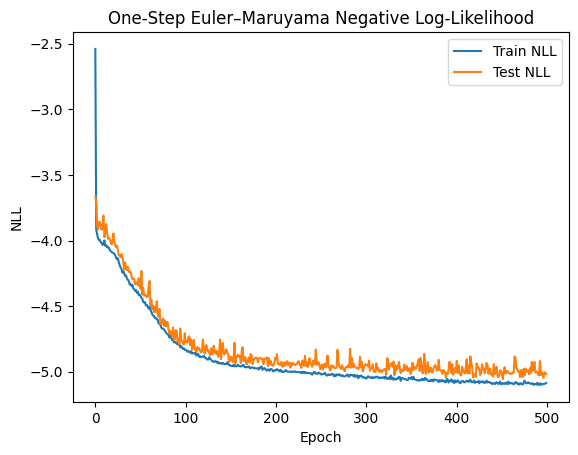

In [8]:
import torch.nn as nn
# Test and train tensors
train_tensor_af = torch.load("train_tensor_af.pt")
test_tensor_af = torch.load("test_tensor_af.pt")

# Load dt tensor
dt_test = torch.load("dt_test.pt")
dt_train = torch.load("dt_train.pt")


surf_train = train_tensor_af
surf_test = test_tensor_af

device = "cuda" if torch.cuda.is_available() else "cpu"
surf_train = surf_train.to(device)
surf_test = surf_test.to(device)
n_train = surf_train.size(0)
n_test  = surf_test.size(0)
n_train, dim = surf_train.shape
n_test, _ = surf_test.shape

# align dt
dt_train = dt_train.to(device)
dt_test = dt_test.to(device)

# Define dt pairs for each surface
dt_train_pairs = dt_train[1:].view(-1, 1)
dt_test_pairs = dt_test[1:].view(-1, 1)


# 3) Define the neural SDE on R^N
class SurfaceSDE(torchsde.SDEIto):
    def __init__(self, dim):
        super().__init__(noise_type="diagonal")
        # Drift network
        self.f_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim)
        )
        # Diffusion network (output ≥ 0)
        self.g_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim),
            nn.Softplus()
        )

    def f(self, t, y):
        return self.f_net(y)

    def g(self, t, y):
        return self.g_net(y)

model = SurfaceSDE(dim).to(device)

# 4) Training setup
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 500
batch_size = 60


train_losses = []
test_losses = []

# 5) Training loop with likelihood-based loss
for epoch in range(n_epochs):
    model.train()
    perm = torch.randperm(n_train - 1)
    epoch_loss = 0.0

    for idx in perm.split(batch_size):
        y0 = surf_train[idx]       # [batch_size, N]
        y1 = surf_train[idx + 1]   # next step
        # Compute drift and diffusion
        drift = model.f(0, y0)     # [batch_size, N]
        diff = model.g(0, y0)      # [batch_size, N]
        # Compute increments
        dy = y1 - y0
        dt = dt_train_pairs[idx]   # [batch_size, 1]
        
        var = (diff ** 2) * dt + 1e-6  # variance per coordinate
        # Negative log-likelihood per coordinate
        nll = 0.5 * ((dy - drift * dt)**2 / var + torch.log(2 * math.pi * var))
        loss = nll.mean()
        if torch.isnan(loss):
            print("NaN in NLL: ",
                  "var min/max:", var.min().item(), var.max().item(),
                  "drift min/max:", drift.min().item(), drift.max().item(),
                  "diff min/max:", diff.min().item(), diff.max().item(),
                  "dy min/max:", dy.min().item(), dy.max().item(),
                  "dt min/max:", dt.min().item(), dt.max().item())
            raise RuntimeError("NaN in loss")

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
        optimizer.step()

        epoch_loss += loss.item() * y0.size(0)

    train_loss = epoch_loss / (n_train - 1)
    train_losses.append(train_loss)

    # 6) Evaluate on test one-step
    model.eval()
    with torch.no_grad():
        y0_test = surf_test[:-1]
        y1_test = surf_test[1:]
        print(y0_test.numel())
        y0_test = surf_test[:-1]
        y1_test = surf_test[1:]
        dt = dt_test_pairs
        drift_t = model.f(0, y0_test)
        diff_t = model.g(0, y0_test)
        dy_t = y1_test - y0_test
        var_t = (diff_t ** 2) * dt + 1e-6
        nll_t = 0.5 * ((dy_t - drift_t * dt)**2 / var_t + torch.log(2 * math.pi * var_t))
        test_loss = nll_t.mean().item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{n_epochs}  Train NLL: {train_loss:.4e}  Test NLL: {test_loss:.4e}")


# 7) Plot training and test NLL curves
plt.figure()
plt.plot(train_losses, label="Train NLL")
plt.plot(test_losses, label="Test NLL")
plt.title("One-Step Euler–Maruyama Negative Log-Likelihood")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.legend()
plt.show()